In [13]:
!python -m spacy download en_core_web_sm -q

2023-04-09 09:25:01.214752: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 37.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [23]:
import gensim.downloader as api
import spacy

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# For plotting the Confusion Matrxix
import matplotlib.pyplot as plt
import seaborn as sn

## Initialize the NLP Object

In [17]:
nlp = spacy.load("en_core_web_sm")

## Initializing the Object for the Word Embeddings

In [5]:
wv = api.load("word2vec-google-news-300")

[==================================================] 100.0% 1662.8/1662.8MB downloaded


## Loading the Dataset

In [6]:
from pathlib import Path
import zipfile


zip_path = Path("/content/fake_news.zip")
dest_dir = Path("/content")

if not dest_dir.is_file():
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        print(f"[INFO] Unzipping dataset `{zip_path}` to `{dest_dir}`...")
        zip_ref.extractall(dest_dir)

print(f"[INFO] Dataset succesfully downloaded to `{dest_dir}`..")

[INFO] Unzipping dataset `/content/fake_news.zip` to `/content`...
[INFO] Dataset succesfully downloaded to `/content`..


## Preprocessing the Dataset

In [9]:
df_true = pd.read_csv(dest_dir / "True.csv")
df_fake = pd.read_csv(dest_dir / "Fake.csv")

df_true["label"] = df_true["text"].apply(lambda x: 0)
df_true = df_true[["text", "label"]].sample(min(df_true.shape[0], df_fake.shape[0]))

df_fake["label"] = df_fake["text"].apply(lambda x: 1)
df_fake = df_fake[["text", "label"]].sample(min(df_true.shape[0], df_fake.shape[0]))

df = pd.concat([df_true, df_fake], ignore_index=True)

print(df.shape)
df

(42834, 2)


,text,label
0,NEW YORK (Reuters) - More than 60 percent of A...,0
1,WASHINGTON (Reuters) - White House spokesman J...,0
2,(Reuters) - Senior FBI officials who helped pr...,0
3,"WARSAW, Poland (Reuters) - President Barack Ob...",0
4,LONDON (Reuters) - An attempt to change the la...,0
...,...,...
42829,Reality TV star and presumptive Republican pre...,1
42830,Who still thinks Trump was wrong to say we nee...,1
42831,Here is a screen shot of the Facebook post by ...,1
42832,"Haha! No, it s not Ted Cruz but a total nut jo...",1


In [10]:
df.value_counts("label")

label
0    21417
1    21417
dtype: int64

In [18]:
df["text_vector"] = df["text"].apply(lambda x: wv.get_mean_vector([token.lemma_ for token in nlp(x) if (not token.is_stop) and (not token.is_punct)]))

## Splitting the Dataset into Training and Testing Sets

In [20]:
test_prop = 0.2

x_train, x_test, y_train, y_test = train_test_split(
    df["text_vector"].values,
    df["label"].values,
    test_size = test_prop,
    stratify = df["label"]
)

print(len(x_train), len(y_train), len(x_test), len(y_test))

34267 34267 8567 8567


## Reshaping X to be compatable with the Model

ndarray of ndarrays -> 2d ndarray

In [22]:
x_train = np.stack(x_train)
x_test = np.stack(x_test)

## Initalizing and Evaluating the Model

In [24]:
clf = GradientBoostingClassifier()

clf.fit(x_train, y_train)

y_preds = clf.predict(x_test)

print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      4283
           1       0.97      0.95      0.96      4284

    accuracy                           0.96      8567
   macro avg       0.96      0.96      0.96      8567
weighted avg       0.96      0.96      0.96      8567



## Plotting Confusion Matrix

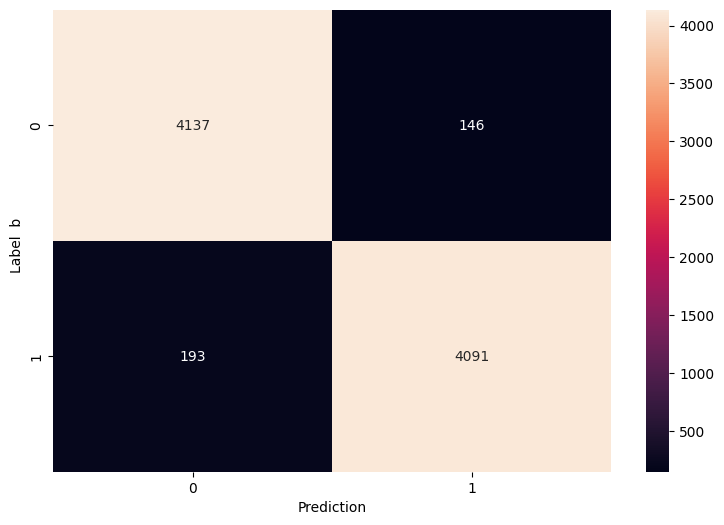

In [28]:
cm = confusion_matrix(y_test, y_preds)

plt.figure(figsize=(9, 6))
sn.heatmap(cm, annot=True, fmt="d")
plt.xlabel("Prediction")
plt.ylabel("Label  b  ");